In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn import ensemble

In [2]:
zori = pd.read_csv('./data/cleandata/clean_zori.csv').drop('Unnamed: 0', axis = 1)
zhvi = pd.read_csv('./data/cleandata/clean_zhvi.csv').drop('Unnamed: 0', axis = 1)
airq = pd.read_csv('./data/cleandata/clean_airq.csv').drop('Unnamed: 0', axis = 1)
population = pd.read_csv('./data/cleandata/clean_population.csv').drop('Unnamed: 0', axis = 1)
unemployment = pd.read_csv('./data/cleandata/clean_unemployment.csv').drop('Unnamed: 0', axis = 1)
education = pd.read_csv('./data/cleandata/clean_education.csv').drop('Unnamed: 0', axis = 1)
permits = pd.read_csv('./data/cleandata/clean_permits.csv').drop('Unnamed: 0', axis = 1)
IandH = pd.read_csv('./data/cleandata/clean_IandH.csv').drop('Unnamed: 0', axis = 1)
pce = pd.read_csv('./data/cleandata/clean_pce.csv').drop('Unnamed: 0', axis = 1)
vacancy = pd.read_csv('./data/cleandata/clean_vacancy.csv').drop('Unnamed: 0', axis = 1)

In [3]:
one_year_forecast = zori[['Year', 'Month', 'Year_Month']]
one_year_forecast = pd.concat([one_year_forecast, pd.DataFrame(one_year_forecast['Year'].map(lambda year: year - 1))], 
                             axis = 1)
one_year_forecast.columns = ['Year', 'Month', 'Year_Month', 'Year2']
one_year_forecast = pd.concat([one_year_forecast, pd.DataFrame(one_year_forecast['Year'].map(lambda year: year - 2))], 
                             axis = 1)
one_year_forecast.columns = ['Year', 'Month', 'Year_Month', 'Year2', 'Year3']
one_year_forecast['Year_Month2'] = one_year_forecast['Year2'].map(str) + '_' + one_year_forecast['Month'].map(str)
one_year_forecast['Year_Month3'] = one_year_forecast['Year3'].map(str) + '_' + one_year_forecast['Month'].map(str)
one_year_forecast = one_year_forecast[['Year_Month', 'Year_Month2', 'Year_Month3']]
one_year_forecast.drop_duplicates(inplace = True)

In [66]:
df = zori
df = pd.merge(df, one_year_forecast, on = 'Year_Month')

In [67]:
df = pd.merge(df, zhvi[['Year_Month', 'ZipCode', 'ZHVI']], left_on = ['Year_Month', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')

In [68]:
df = pd.merge(df, airq[['County', 'State', 'Year_Month', 'AQI']], left_on = ['County', 'State', 'Year_Month'],
              right_on = ['County', 'State', 'Year_Month'], how = 'left')

In [69]:
df = pd.merge(df, population[['County', 'State', 'Year_Month', 'Population']], 
              left_on = ['County', 'State', 'Year_Month'], right_on = ['County', 'State', 'Year_Month'], how = 'left')

In [70]:
df = pd.merge(df, unemployment[['County', 'State', 'Year_Month', 'Unemployment']], 
             left_on = ['County', 'State', 'Year_Month'], right_on = ['County', 'State', 'Year_Month'], how = 'left')

In [71]:
df = pd.merge(df, education, left_on = ['County', 'State', 'Year'], right_on = ['County', 'State', 'Year'], how = 'left')

In [72]:
df = pd.merge(df, permits[['State', 'Units', 'Year_Month']], left_on = ['State', 'Year_Month'], 
              right_on = ['State', 'Year_Month'], how = 'left')

In [73]:
df = pd.merge(df, IandH[['County', 'State', 'Year_Month', 'Total_Households', 'Med_income']], 
             left_on = ['County', 'State', 'Year_Month'], right_on = ['County', 'State', 'Year_Month'], how = 'left')

In [74]:
df = pd.merge(df, pce[['PCE', 'Year_Month']], left_on = 'Year_Month', right_on = 'Year_Month')

In [75]:
df = pd.merge(df, vacancy, left_on = ['County', 'State', 'Year'], right_on = ['County', 'State', 'Year'], how = 'left')

In [76]:
df = df[['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI', 'AQI', 'Population', 'Unemployment', 
         'Percent Bachelors', 'Units', 'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate']]

In [77]:
# Dropping all NaN values instead of imputing for simplicity for now
df = df[(df['Year'] != 2014) & ~((df['Year'] == 2015) & (df['Month'] == 1))]
df = df[~df['Total_Households'].isnull()]
df = df[~df['ZORI'].isnull()]
df = df[~df['ZHVI'].isnull()]
df = df[~df['AQI'].isnull()]
df = df[~df['Rental Vacancy Rate'].isnull()]
df2 = df[df['ZORI']<4000].copy() #taking only ZORI < 4000
#df2 = df[df['Year'] != 2020].copy() #drop 2020 since it is an anomolous year with COVID
#train = df[df['Year'] != 2019]
#test = df[df['Year'] == 2020]

<AxesSubplot:xlabel='Unemployment', ylabel='ZORI'>

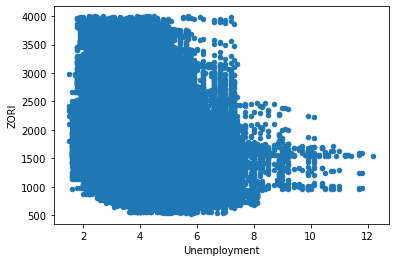

In [93]:
%matplotlib inline
df[df['ZORI']<4000].plot.scatter(x='Unemployment',y='ZORI')

<AxesSubplot:xlabel='Percent Bachelors', ylabel='ZORI'>

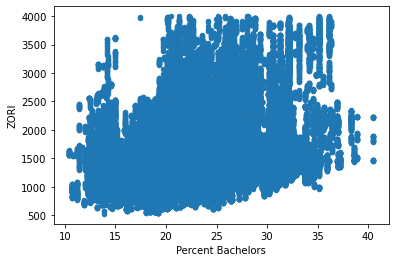

In [94]:
df[df['ZORI']<4000].plot.scatter(x='Percent Bachelors',y='ZORI')

<AxesSubplot:xlabel='Med_income', ylabel='ZORI'>

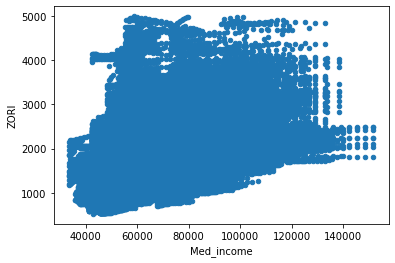

In [101]:
df[df['ZORI']<5000].plot.scatter(x='Med_income',y='ZORI')

In [78]:
regression = LinearRegression()
regression.fit(df.iloc[:, 4:], df.iloc[:, 3])
regression.score(df.iloc[:, 4:], df.iloc[:, 3])

0.22972810675673438

In [79]:
regression2 = LinearRegression()
regression2.fit(df2.iloc[:, 4:], df2.iloc[:, 3])
regression2.score(df2.iloc[:, 4:], df2.iloc[:, 3])

0.7315064661331103

In [106]:
df2.reset_index(inplace = True)
df2.drop('index', axis=1, inplace=True)
train_idx = np.random.choice(range(df2.shape[0]), round(0.7 * df2.shape[0]), replace = False)
test_idx = df2.index[~df2.index.isin(train_idx)]
train = df2.iloc[train_idx, :]
test = df2.iloc[test_idx, :]

In [107]:
regression3 = LinearRegression()
regression3.fit(train.iloc[:, 4:], train.iloc[:, 3])
regression3.score(train.iloc[:, 4:], train.iloc[:, 3])

0.7297245817868043

In [108]:
r2_score(test.iloc[:, 3], regression3.predict(test.iloc[:, 4:]))

0.7356098692465869

In [110]:
c_values = pd.Series(regression2.coef_, index = df2.iloc[:, 4:].columns).sort_values()
pd.DataFrame(c_values, columns = ['coefficients'])

,coefficients
Rental Vacancy Rate,-3.590559
Percent Bachelors,-2.573306
AQI,-1.668358
Population,-0.000009
Total_Households,0.000061
ZHVI,0.001476
Med_income,0.006361
Units,0.032709
Unemployment,7.182334
PCE,63.603863


In [ ]:
value_f, p_f = f_regression(df2.iloc[:, 4:], df2.iloc[:, 3])
mutual_scores = mutual_info_regression(df2.iloc[:, 4:], df2.iloc[:, 3])

In [111]:
p_values = pd.Series(p_f, index = df2.iloc[:, 4:].columns).sort_values()
pd.DataFrame(p_values.head(25), columns = ['p-values'])

,p-values
ZHVI,0.000000e+00
Population,0.000000e+00
Unemployment,0.000000e+00
Percent Bachelors,0.000000e+00
Units,0.000000e+00
Total_Households,0.000000e+00
Med_income,0.000000e+00
Rental Vacancy Rate,0.000000e+00
PCE,1.086944e-322
AQI,2.136816e-226


In [112]:
mutual_score_values = pd.Series(mutual_scores, index = df2.iloc[:, 4:].columns).sort_values(ascending = False)
pd.DataFrame({'mutual information scores':mutual_score_values, 'p_values':p_values, 'coefficients':c_values})

,mutual information scores,p_values,coefficients
AQI,0.061494,2.136816e-226,-1.668358
Med_income,0.218119,0.000000e+00,0.006361
PCE,0.012461,1.086944e-322,63.603863
Percent Bachelors,0.468714,0.000000e+00,-2.573306
Population,0.365119,0.000000e+00,-0.000009
Rental Vacancy Rate,0.304485,0.000000e+00,-3.590559
Total_Households,0.375657,0.000000e+00,0.000061
Unemployment,0.050309,0.000000e+00,7.182334
Units,0.166772,0.000000e+00,0.032709
ZHVI,0.888186,0.000000e+00,0.001476


In [113]:
regression2.coef_

array([ 1.47575942e-03, -1.66835759e+00, -8.88584880e-06,  7.18233412e+00,
       -2.57330583e+00,  3.27091477e-02,  6.07732297e-05,  6.36081944e-03,
        6.36038627e+01, -3.59055881e+00])

In [109]:
randomForest = ensemble.RandomForestRegressor()

grid_para_forest = [{
    "n_estimators": [50],
    "criterion": ["mse"],
    "min_samples_leaf": [5],
    "min_samples_split": np.linspace(start = 10, stop = 30, num = 5, dtype = int),
    "random_state": [42]}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv = 5, n_jobs = -1)
grid_search_forest.fit(train.iloc[:, 4:], train.iloc[:, 3])

KeyboardInterrupt: 